<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

# Chapter 2

In [12]:
import numpy as np
import dask.array as da
import h5py
import matplotlib.pyplot as plt

In [22]:
data = h5py.File('./Texas/texas.2000.hdf5', 'r')
list(data.keys())
energy = np.array(data['load'])
energy

array([5282.56, 5267.62, 5252.65, ..., 5136.65, 5138.3 , 5139.89])

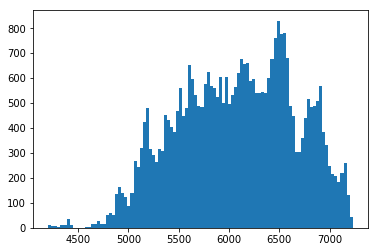

In [23]:
plt.hist(energy, bins=100)
plt.show()

In [24]:
# Call da.from_array():  energy_dask
energy_dask = da.from_array(energy, chunks=energy.shape[0]//4)

# Print energy_dask.chunks
print(energy_dask.chunks)

# Print Dask array average and then NumPy array average
print(energy_dask.mean().compute())
print(energy.mean())

((8784, 8784, 8784, 8784),)
6077.886444672131
6077.886444672131


In [27]:
# Import time
import time

# Call da.from_array() with arr: energy_dask4
energy_dask4 = da.from_array(energy, chunks=energy.shape[0]//4)

# Print the time to compute standard deviation
t_start = time.time()
std_4 = energy_dask4.std()
t_end = time.time()
print((t_end - t_start) * 1.0e3)

2.9838085174560547


In [28]:
# Import time
import time

# Call da.from_array() with arr: energy_dask4
energy_dask8 = da.from_array(energy, chunks=energy.shape[0]//8)

# Print the time to compute standard deviation
t_start = time.time()
std_8 = energy_dask8.std()
t_end = time.time()
print((t_end - t_start) * 1.0e3)

4.287004470825195


In [42]:
data = h5py.File('./Texas/texas.2001.hdf5', 'r')
list(data.keys())
load_2001 = np.array(data['load'])
load_2001.shape

(35040,)

In [46]:
arrs = []

for year in range(2013, 2016):
    data = h5py.File(f'./Texas/texas.{year}.hdf5', 'r')
    arrs.append(np.array(data['load']))

load_recent = np.concatenate(arrs)
load_recent.shape

(105120,)

In [47]:
# Reshape load_recent to three dimensions: load_recent_3d
load_recent_3d = load_recent.reshape((3,365,96))

# Reshape load_2001 to three dimensions: load_2001_3d
load_2001_3d = load_2001.reshape((1,365,96))

# Subtract the load in 2001 from the load in 2013 - 2015: diff_3d
diff_3d = load_recent_3d - load_2001_3d

# Print the difference each year on March 2 at noon
print(diff_3d[:, 61, 48])

[-1153.309    22.598   -17.925]


In [69]:
# Print mean value of load_recent_3d
print(load_recent_3d.mean())

# Print maximum of load_recent_3d across 2nd & 3rd dimensions
print(load_recent_3d.max(axis=(1,2)))

# Compute sum along last dimension of load_recent_3d: daily_consumption
daily_consumption = load_recent_3d.sum(axis=-1)

# Print mean of 62nd row of daily_consumption
print(daily_consumption[:,61].mean())

5240.84666194825
[6335.42  6336.159 6344.077]
470184.43899999995


In [71]:
from glob import glob

filenames = glob('./Texas/*')
print(filenames)

['./Texas/texas.2013.hdf5', './Texas/texas.2015.hdf5', './Texas/texas.2014.hdf5', './Texas/texas.2001.hdf5', './Texas/texas.2000.hdf5']


In [140]:
# This is very different to exercise, could not find source data
# notice you must reshape the data if it is flat, before you
# can chunk it into a different shape - da.from_array will not 
# do that automatically

# Import h5py and dask.array
import dask.array as da
import h5py

# List comprehension to read each file: dsets
dsets = [h5py.File(f, 'r')['load'] for f in filenames[:-1:]]

# concat arrays
arrs = [np.array(d).reshape(365,96) for d in dsets]

# List comprehension to make dask arrays: monthly
monthly = [da.from_array(arr, chunks=(365,96)) for arr in arrs]
print(monthly)

[dask.array<array, shape=(365, 96), dtype=float64, chunksize=(365, 96)>, dask.array<array, shape=(365, 96), dtype=float64, chunksize=(365, 96)>, dask.array<array, shape=(365, 96), dtype=float64, chunksize=(365, 96)>, dask.array<array, shape=(365, 96), dtype=float64, chunksize=(365, 96)>]


In [142]:
# Stack with the list of dask arrays: by_year
by_year = da.stack(monthly, axis=0)

# Print the shape of the stacked arrays
print(by_year.shape)

# Read the climatology data: climatology
dset = h5py.File('tmax.climate.hdf5')
climatology = da.from_array(dset['/tmax'], chunks=(1,444,922))

# Reshape the climatology data to be compatible with months
climatology.reshape(1,12,444,922)

(4, 365, 96)


KeyError: "Unable to open object (object 'tmax' doesn't exist)"

In [143]:
# Compute the difference: diff
diff = (by_year - climatology) * 9/5
# Compute the average over last two axes: avg
avg = da.nanmean(diff, axis=(-1,-2)).compute()
# Plot the slices [:,0], [:,7], and [:11] against the x values
x = range(2008,2012)
f, ax = plt.subplots()
ax.plot(x,avg[:,0], label='Jan')
ax.plot(x,avg[:,7], label='Aug')
ax.plot(x,avg[:,11], label='Dec')
ax.axhline(0, color='red')
ax.set_xlabel('Year')
ax.set_ylabel('Difference (degrees Fahrenheit)')
ax.legend(loc=0)
plt.show()

NameError: name 'climatology' is not defined